## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal
from scipy import stats

In [3]:
from sonar import sonar, utils
import math

In [4]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [6]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


## real tissue example

In [7]:
# sample_list = []
# for sample in range(1,5):
#     n_sample = sample

#     tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
#     # Islet stack
#     rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
#     rescaled_splitted = np.split(rescaled, 16)
#     islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
#     sample_list.append(islet_stack)


Text(0.5, 1.0, 'Sample4, scaling = 0.3')

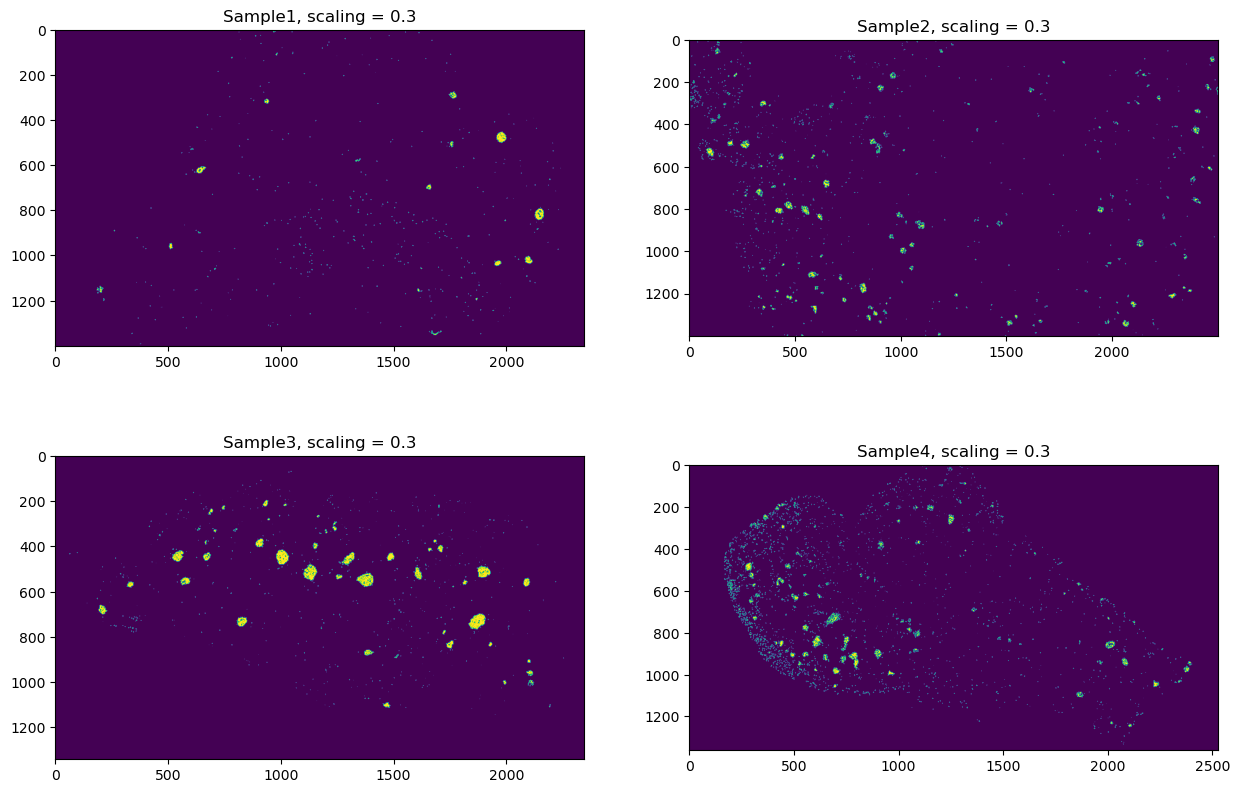

In [41]:
# plt.figure(figsize=(15,10))

# plt.subplot(2,2,1)
# plt.imshow(sample_list[0][0][200:1600,:])
# plt.title("Sample1, scaling = 0.3")

# plt.subplot(2,2,2)
# plt.imshow(sample_list[1][0][350:1750,500:3000])
# plt.title("Sample2, scaling = 0.3")

# plt.subplot(2,2,3)
# plt.imshow(sample_list[2][0].T)
# plt.title("Sample3, scaling = 0.3")

# plt.subplot(2,2,4)
# plt.imshow(sample_list[3][0][200:,:])
# plt.title("Sample4, scaling = 0.3")

# hexagonal grid, tissue simulation

In [49]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
N = 1000

ratio = np.sqrt(3)/2 # cos(60°)
N_X = int(np.sqrt(N/ratio))
N_Y = N // (N_X)

xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
xv = xv * ratio
xv[::2, :] += ratio/2

(-1.407291281149713, 29.55311690414397, -1.4500000000000002, 30.45)

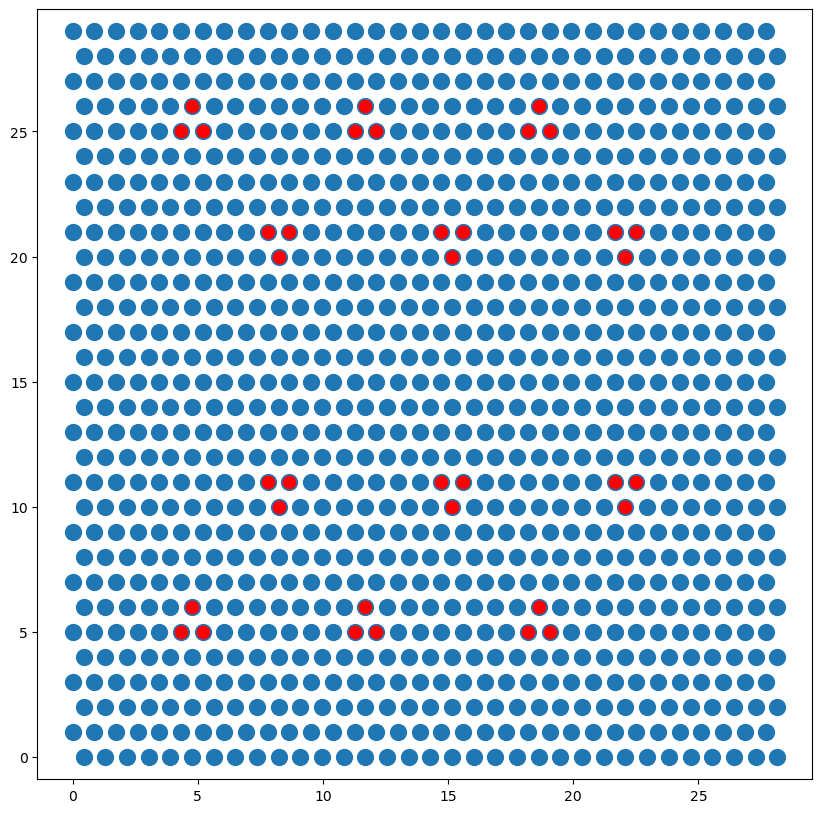

In [102]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.scatter(xv, yv, s=130)

# xv[3,5]=np.nan
# yv[3,5] = np.nan

def islet(upper, down_c, left_c, right_c):
    ax.scatter(xv[down_c,left_c], yv[down_c,left_c], s=80, c='red')  # You can change 'red' to any other color
    ax.scatter(xv[upper,left_c], yv[upper,left_c], s=80, c='red')
    ax.scatter(xv[down_c,right_c], yv[down_c,right_c], s=80, c='red')

islet(26,25,5,6)
islet(26,25,13,14)
islet(26,25,21,22)

islet(20,21,9,10)
islet(20,21,17,18)
islet(20,21,25,26)


islet(6,5,5,6)
islet(6,5,13,14)
islet(6,5,21,22)

islet(10,11,9,10)
islet(10,11,17,18)
islet(10,11,25,26)



ax.axis('equal')

In [103]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor((xv, yv),interpolate=True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650977166858/work/torch/csrc/utils/tensor_new.cpp:207.)
  hists = t.tensor(hists,dtype=torch.float32,device=self.device)


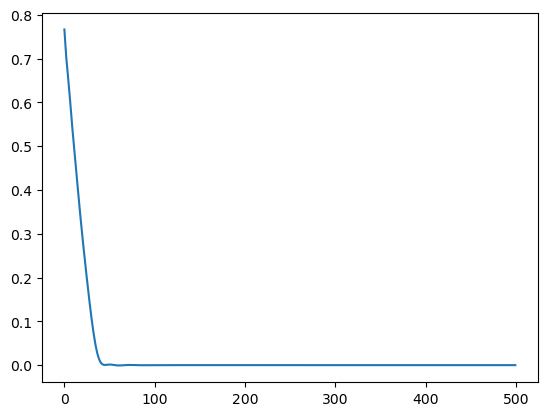

In [106]:
plt.plot(cooc_template_[0,1])

# Tissues, sonar

In [142]:
n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

In [146]:
# Islet stack
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
# rescaled_splitted = np.split(rescaled, 16)
# islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:204: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


(-0.001, 0.01)

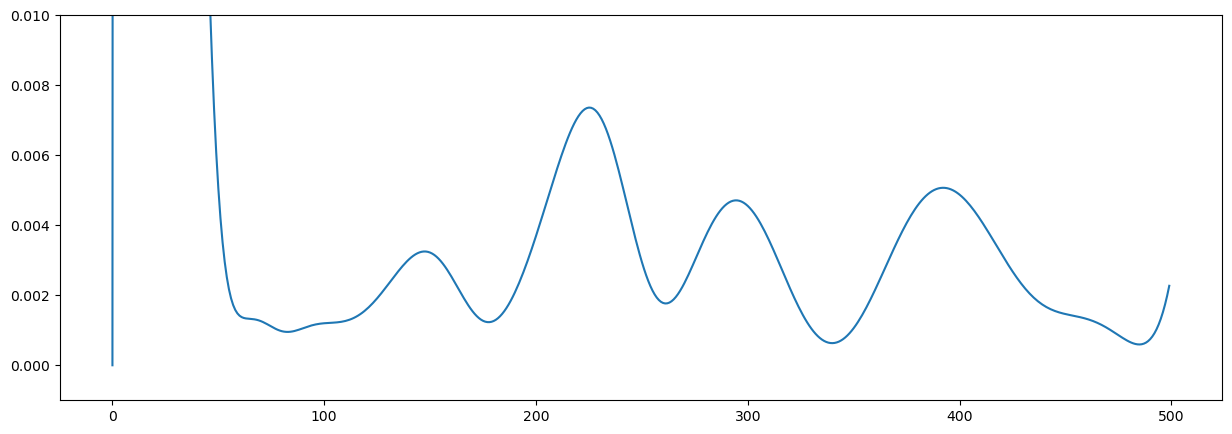

In [93]:
# plt.figure(figsize=[15,5])
# plt.plot(cooc_template_[6,7])
# plt.ylim(-0.001,0.01)

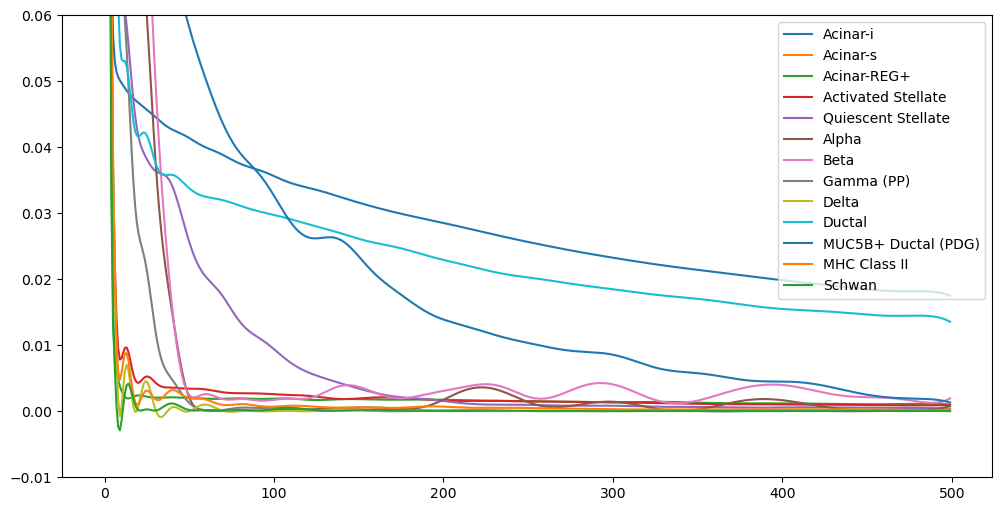

In [147]:
plt.figure(figsize=[12,6])

for i in range(1,14):
    # plt.plot(cooc_template_[6,7])
    plt.plot(cooc_template_[i,i])

# plt.plot(cooc_template_islet[0,0])
plt.ylim(-0.01,0.06)
plt.legend(cluster_labels[1:14], loc="upper right")

76427.0
696597.0
4112.0
3774.0
4405.0
2195.0
7873.0
547.0
249.0
56161.0
8143.0
1017.0
222.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Acinar-i'),
  Text(1, 0, 'Acinar-s'),
  Text(2, 0, 'Acinar-REG+'),
  Text(3, 0, 'Activated Stellate'),
  Text(4, 0, 'Quiescent Stellate'),
  Text(5, 0, 'Alpha'),
  Text(6, 0, 'Beta'),
  Text(7, 0, 'Gamma (PP)'),
  Text(8, 0, 'Delta'),
  Text(9, 0, 'Ductal'),
  Text(10, 0, 'MUC5B+ Ductal (PDG)'),
  Text(11, 0, 'MHC Class II'),
  Text(12, 0, 'Schwan')])

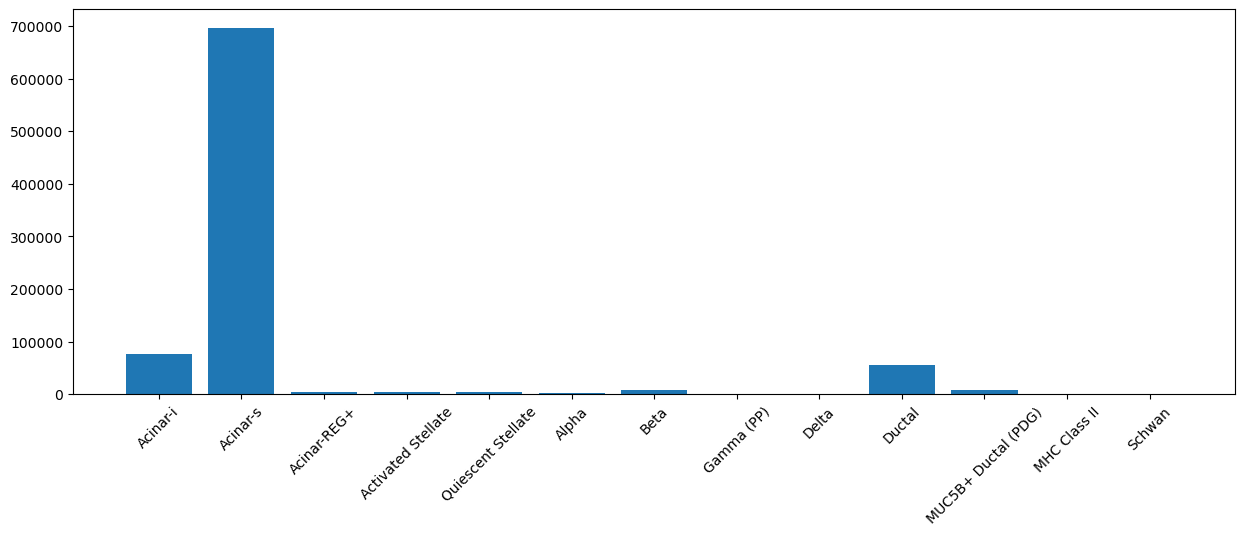

In [68]:
plt.figure(figsize=[15,5])
tissue_pixels = []
for i in range(1,14):
    pix_agreg = np.sum(rescaled[i])
    tissue_pixels.append(pix_agreg)
    print(pix_agreg)

plt.bar(cluster_labels[1:14],tissue_pixels)
plt.xticks(rotation=45)

Probability distribution

In [79]:
probab_distr = []
for cell_type in tissue_pixels:
    p_cell_type = cell_type/sum(tissue_pixels)
    probab_distr.append(p_cell_type)
print(probab_distr)

[0.08869101636026468, 0.8083778759275033, 0.0047718405703927715, 0.0043796027024957, 0.005111857420374552, 0.0025472252072013942, 0.009136357201046276, 0.0006347754844369762, 0.0002889562991312744, 0.06517299082534739, 0.00944968330853802, 0.0011801950048855663, 0.00025762368838210003]


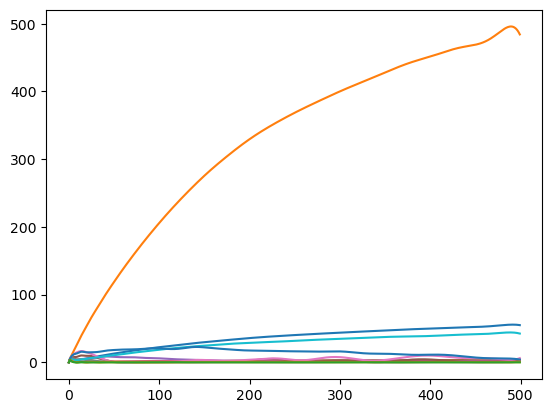

In [104]:
for rad in range(500):
    cooc_template_changed[:,:,rad] = cooc_template_[:,:,rad]*2*math.pi*rad

for i in range(1,14):
    # plt.plot(cooc_template_[6,7])
    plt.plot(cooc_template_changed[i,i])

In [ ]:
# test with 3 uniformly distributed values

co_occurrence_test

In [313]:
scipy.stats.binomtest(int(cooc_template_changed[6,6][200]), int(200*2*math.pi), p=probab_distr[6])

BinomTestResult(k=2, n=1256, alternative='two-sided', statistic=0.0015923566878980893, pvalue=0.0015561304470760793)